In [1]:
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image

In [2]:
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout, Lambda

In [3]:
!pwd

/Users/brncat/Downloads/AltaVerde/GitHub/fruit_detection/notebook


In [4]:
base_image_path = tf.keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = tf.keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = tf.keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

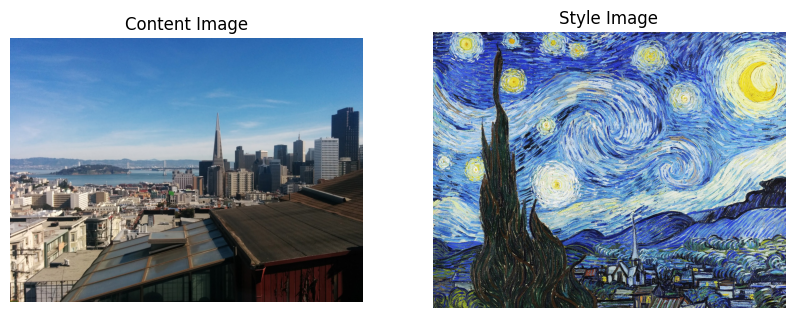

In [5]:
# plot content and style images
plt.figure(figsize=(10, 5))
content = Image.open(base_image_path)
style = Image.open(style_reference_image_path)
plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title("Content Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title("Style Image")
plt.axis("off")
plt.show()

In [6]:
def preprocess_image(image_path, target_size=(img_height, img_width, 3)):
    img = tf.keras.utils.load_img(
        image_path, target_size=target_size)
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img, target_size=(img_height, img_width, 3)):
    # revert the preprocessing by VGG19
    # remove zero-center by mean pixel value of ImageNet.
    img = img.reshape(target_size)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # Also, convert back from 'BGR' to 'RGB'.
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


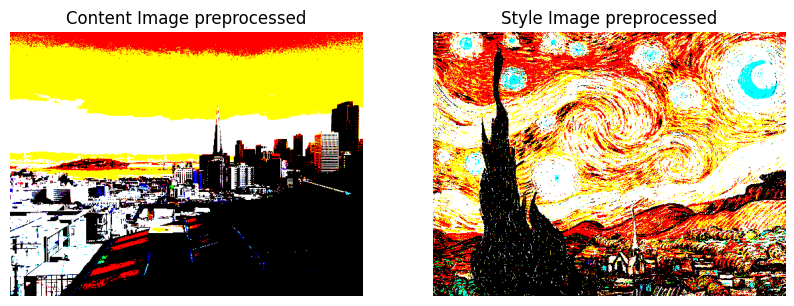

In [7]:
# plot content and style images
plt.figure(figsize=(10, 5))
content = preprocess_image(base_image_path)
style = preprocess_image(style_reference_image_path)
plt.subplot(1, 2, 1)
plt.imshow(content[0])
plt.title("Content Image preprocessed")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(style[0])
plt.title("Style Image preprocessed")
plt.axis("off")
plt.show()

(400, 533, 3)
(1, 400, 533, 3)


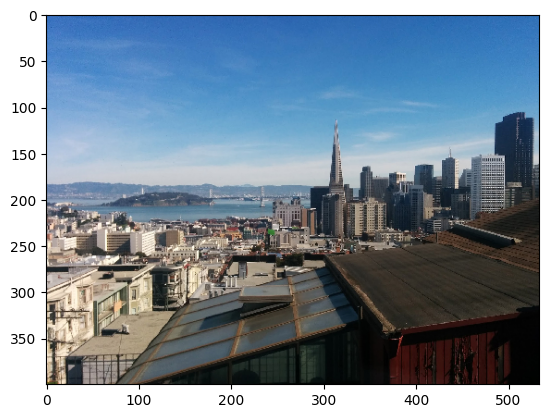

In [8]:
imgh = deprocess_image(content[0])
print(imgh.shape)
print(content.shape)
plt.imshow(imgh)

### Define the base, style and combination images for transfer learning

In [9]:
# define the submodel
submodel = VGG16(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)
# submodel.summary()
# notice that submodel doen't show the input layer


# The next step is super important to capture the activations of intermediate layers!
# get the outputs of the intermediate layers
outputs_dict = dict([(layer.name, layer.output) for layer in submodel.layers])

# create a model that returns these outputs given the model input
model = tf.keras.Model(inputs=submodel.inputs, outputs=outputs_dict)
model.summary() # Notice that model shows the input layer

# later it will be important to have the outputs as a dictionary
# to capture the activations of the intermediate layers

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 533, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 533, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 533, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 266, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 266, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 266, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 133, 128)     0     

In [10]:
outputs_dict

{'input_1': <KerasTensor: shape=(None, 400, 533, 3) dtype=float32 (created by layer 'input_1')>,
 'block1_conv1': <KerasTensor: shape=(None, 400, 533, 64) dtype=float32 (created by layer 'block1_conv1')>,
 'block1_conv2': <KerasTensor: shape=(None, 400, 533, 64) dtype=float32 (created by layer 'block1_conv2')>,
 'block1_pool': <KerasTensor: shape=(None, 200, 266, 64) dtype=float32 (created by layer 'block1_pool')>,
 'block2_conv1': <KerasTensor: shape=(None, 200, 266, 128) dtype=float32 (created by layer 'block2_conv1')>,
 'block2_conv2': <KerasTensor: shape=(None, 200, 266, 128) dtype=float32 (created by layer 'block2_conv2')>,
 'block2_pool': <KerasTensor: shape=(None, 100, 133, 128) dtype=float32 (created by layer 'block2_pool')>,
 'block3_conv1': <KerasTensor: shape=(None, 100, 133, 256) dtype=float32 (created by layer 'block3_conv1')>,
 'block3_conv2': <KerasTensor: shape=(None, 100, 133, 256) dtype=float32 (created by layer 'block3_conv2')>,
 'block3_conv3': <KerasTensor: shape=(

In [11]:
# print(submodel.inputs)
# print(submodel.outputs)

# output 
# [<KerasTensor: shape=(None, 400, 533, 3) dtype=float32 (created by layer 'input_1')>]
# [<KerasTensor: shape=(None, 25, 33, 512) dtype=float32 (created by layer 'block5_conv3')>]


# print(type(model.outputs))
# model.outputs

# output
# <class 'dict'>
# [<KerasTensor: shape=(None, 400, 533, 64) dtype=float32 (created by layer 'block1_conv1')>,
#  <KerasTensor: shape=(None, 400, 533, 64) dtype=float32 (created by layer 'block1_conv2')>,
#  <KerasTensor: shape=(None, 200, 266, 64) dtype=float32 (created by layer 'block1_pool')>,
#  <KerasTensor: shape=(None, 200, 266, 128) dtype=float32 (created by layer 'block2_conv1')>,
#  <KerasTensor: shape=(None, 200, 266, 128) dtype=float32 (created by layer 'block2_conv2')>,
#  <KerasTensor: shape=(None, 100, 133, 128) dtype=float32 (created by layer 'block2_pool')>,
#  <KerasTensor: shape=(None, 100, 133, 256) dtype=float32 (created by layer 'block3_conv1')>,
#  <KerasTensor: shape=(None, 100, 133, 256) dtype=float32 (created by layer 'block3_conv2')>,
#  <KerasTensor: shape=(None, 100, 133, 256) dtype=float32 (created by layer 'block3_conv3')>,
#  <KerasTensor: shape=(None, 50, 66, 256) dtype=float32 (created by layer 'block3_pool')>,
#  <KerasTensor: shape=(None, 50, 66, 512) dtype=float32 (created by layer 'block4_conv1')>,
#  <KerasTensor: shape=(None, 50, 66, 512) dtype=float32 (created by layer 'block4_conv2')>,
#  <KerasTensor: shape=(None, 50, 66, 512) dtype=float32 (created by layer 'block4_conv3')>,
#  <KerasTensor: shape=(None, 25, 33, 512) dtype=float32 (created by layer 'block4_pool')>,
#  <KerasTensor: shape=(None, 25, 33, 512) dtype=float32 (created by layer 'block5_conv1')>,
#  <KerasTensor: shape=(None, 25, 33, 512) dtype=float32 (created by layer 'block5_conv2')>,
#  <KerasTensor: shape=(None, 25, 33, 512) dtype=float32 (created by layer 'block5_conv3')>]

---

In [12]:
def content_loss(base, generated):
    """ content loss will make sure that the top layer of VGG16 has a
        similar view of the base image
        
        base: the activations of the intermediate layer of the base image
        generated: the activations of the intermediate layer of the generated image
    """
    
    return K.sum(K.square(generated - base))

In [13]:
def gram_matrix(x):
    """ the gram matrix of an image tensor (feature map) is the dot product of the
        reshaped tensor with its transpose"""
    
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def style_loss(style, generated):
    """ style loss is the sum of the squared differences between the gram matrices of the
        style image and the generated image"""
    
    S = gram_matrix(style)
    G = gram_matrix(generated)
    channels = 3
    size = img_height * img_width
    
    return K.sum(K.square(S - G)) / (4.0 * (channels ** 2) * (size ** 2))

In [14]:
# here is an example of what permute_dimensions does

# x = tf.constant(np.random.randn(3, 400, 533).astype(np.float32))
# print("x :", x.shape)
# y = K.permute_dimensions(x, (2, 0, 1))
# print("y :", y.shape)
# z = K.batch_flatten(y)
# print("z :", z.shape)
# g = tf.matmul(z, tf.transpose(z))
# print("g :", g.shape)

# output
# x : (3, 400, 533)
# y : (533, 3, 400)
# z : (533, 1200)
# g : (533, 533)

In [15]:
# x = tf.constant(np.random.randn(3, 400, 533).astype(np.float32))
# print("x.shape :", x.shape)
# g = gram_matrix(x)
# print("g.shape :", g.shape)

# output
# x.shape : (3, 400, 533)
# g.shape : (533, 533)

In [16]:
def total_variation_loss(x):
    """ total variation loss is the sum of the squared differences between the pixels of the
        generated image and the pixels of the generated image shifted by one pixel in both
        the horizontal and vertical directions.
        This loss is used to smooth the generated image"""
    
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])

    return K.sum(K.pow(a + b, 1.25))

In [17]:
base_image = K.constant(preprocess_image(base_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.variable(base_image)

print(base_image.shape, style_reference_image.shape, combination_image.shape)

(1, 400, 533, 3) (1, 400, 533, 3) (1, 400, 533, 3)


---

In [18]:
# THIS BLOCK IS MERELEY FOR TESTING PURPOSES
# IT CAN BE DISREGARDED WITHOUT AFFECTING THE REST OF THE CODE

# for a demonstration, let's see the activations of the block5_conv2 layer
# for the base image, style image and combination image
input_tensor = K.concatenate(
       [base_image, style_reference_image, combination_image], axis=0
    )
print("input_tensor :", input_tensor.shape)
features = model(input_tensor)

print("type(features) :",type(features))
print('features block5_conv2 :', "\n", "shape: ", features['block5_conv2'].shape, "\n", features['block5_conv2'])

print('base_image_features :', "\n", features['block5_conv2'][0, :, :, :].shape)
print('style_reference_features :', "\n", features['block5_conv2'][1, :, :, :].shape)
print('combination_features :', "\n", features['block5_conv2'][2, :, :, :].shape)

input_tensor : (3, 400, 533, 3)
type(features) : <class 'dict'>
features block5_conv2 : 
 shape:  (3, 25, 33, 512) 
 tf.Tensor(
[[[[0.00000000e+00 3.06720734e+01 1.36218977e+01 ... 0.00000000e+00
    9.17959929e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 6.82119703e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 1.24915794e-01 4.27287817e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 2.76186895e+00 2.60209179e+01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.74543972e+01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 3.00492420e+01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]]

  [[3.76049156e+01 2.64712925e+01 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [6.29036102e+01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [5.37447205e+01 0.00000000e+00 0.000

---

Defining the final loss that you'll minimize

In [19]:
# define the names of the layers that will be used to compute the loss
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv3"

# define the weights in the weighted average for the loss components
total_variation_weight = 1e-6
style_weight = 1e-4
content_weight = 1e-8

In [20]:
def input_tensor_concat(base_image, style_reference_image, combination_image):
    return K.concatenate(
       [base_image, style_reference_image, combination_image], axis=0
    )

In [21]:
def compute_loss(base_image, style_reference_image, combination_image):
    """ compute the total loss of the combination image.

        combination_image : the image to be optimized.
        base_image : the image that will be used to compute the content loss.
        style_reference_image : the image that will be used to compute the style loss.
        returns the total loss as a scalar tensor.
    """ 

    input_tensor = input_tensor_concat(base_image, style_reference_image, combination_image)

    # features is a dictionary to capture the activations of the intermediate layers
    features = model(input_tensor) 
    loss =  tf.zeros(shape=()) # loss is a scalar tensor

    # get the activations of the content layer
    layer_features = features[content_layer_name] 
    # separate the activations of the base image and the combination image
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    # compute the content loss
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    
    # compute the style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [22]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=10.,
    decay_steps=10,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule)


In [23]:
@tf.function
def train_step(base_image, style_reference_image, combination_image):
    """ function to be used with tf.GradientTape to compute the gradients of the loss
        with respect to the combination image.
        x : input tensor that contains the combination image (x[2, :, :, :]).
    """
    
    with tf.GradientTape() as tape:
        loss = compute_loss(base_image, style_reference_image, combination_image)
    
    # compute the gradients of the loss with respect to the combination_image
    grads = tape.gradient(loss, combination_image)
    
    # apply the gradients to the combination_image
    optimizer.apply_gradients([(grads, combination_image)])

    return loss, grads

In [24]:
def minimize():

    loss_values = []
    grad_values = []
    iterations = 50
    for i in range(1, iterations+1):
        loss, grads = train_step(base_image, style_reference_image, combination_image)
        loss_values.append(loss)
        grad_values.append(grads)
    
        if i % 10 == 0:
            print("Iteration %d: loss=%.2f" % (i, loss))

    img = deprocess_image(combination_image.numpy())
    fname = "combination_image_at_%d.png" % i
    tf.keras.utils.save_img(fname, img)
    print("Image saved as", fname)
    plt.imshow(img)
    plt.show()

    return [loss_values, grad_values]

Iteration 10: loss=306677.03
Iteration 20: loss=110199.56
Iteration 30: loss=82405.60
Iteration 40: loss=68545.97
Iteration 50: loss=60208.43
Image saved as combination_image_at_50.png


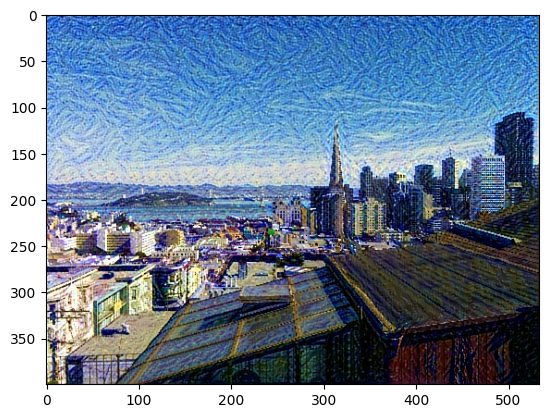

Time taken: 0:01:44.128266
CPU times: user 12min 27s, sys: 49.5 s, total: 13min 17s
Wall time: 1min 44s


In [25]:
%%time
start_datetime = datetime.now()

loss_grads_values = minimize()

end_datetime = datetime.now()
print("Time taken:", end_datetime - start_datetime)

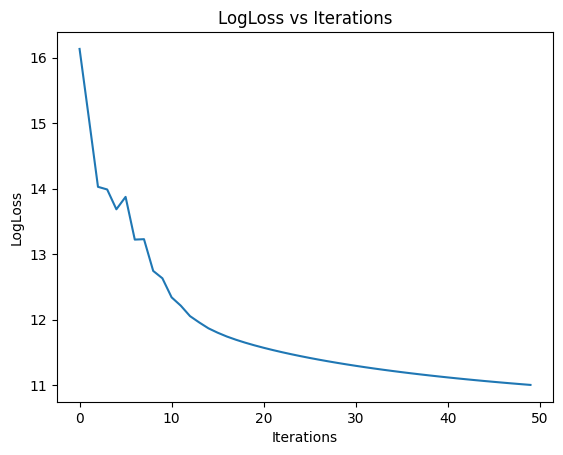

In [26]:
# plot the loss values in log scale

log_loss = [np.log(x) for x in loss_grads_values[0]]
plt.plot(log_loss)
plt.xlabel("Iterations")
plt.ylabel("LogLoss")
plt.title("LogLoss vs Iterations")
plt.show()